In [1]:
import numpy as np
import matplotlib.pyplot as plt
import field
import spatial
import timesteppers
import scipy.sparse.linalg as spla
from scipy.integrate import trapz
from scipy import sparse

from timesteppers import *

from field import *
from spatial import FiniteDifferenceUniformGrid

%matplotlib inline

NameError: name 'field' is not defined

#### $\frac{1}{\mathcal{J}}\frac{\partial f}{\partial t} = \frac{\partial}{\partial E}(D_{EE} f) + D_{EE}\frac{\partial^2 f}{\partial E^2} + \frac{\partial}{\partial E}(D_{ER})\frac{\partial f}{\partial R} + D_{ER}\frac{\partial^2 f}{\partial E \partial R} + \frac{\partial}{\partial E}(D_E)f + D_E\frac{\partial f}{\partial E}+ \frac{\partial}{\partial R}(D_{RE})\frac{\partial f}{\partial E} + D_{RE}\frac{\partial^2 f}{\partial R\partial E} + \frac{\partial}{\partial R}(D_{RR} f) + D_{RR}\frac{\partial^2 f}{\partial R^2} + \frac{\partial}{\partial R}(D_R)f + D_R\frac{\partial f}{\partial R}$

### $ \frac{1}{\mathcal{J}}\frac{\partial f}{\partial t} = \frac{\partial D_{EE}}{\partial E}f + D_{EE}\frac{\partial f}{\partial E} + D_{EE}\frac{\partial^2 f}{\partial E^2} + \frac{\partial}{\partial E}(D_{ER})\frac{\partial f}{\partial R} + D_{ER}\frac{\partial^2 f}{\partial E \partial R} + \frac{\partial}{\partial E}(D_E)f + D_E\frac{\partial f}{\partial E}+ \frac{\partial}{\partial R}(D_{RE})\frac{\partial f}{\partial E} + D_{RE}\frac{\partial^2 f}{\partial R\partial E} + \frac{\partial D_{RR}}{\partial R}f + D_{RR}\frac{\partial f}{\partial R} + D_{RR}\frac{\partial^2 f}{\partial R^2} + \frac{\partial}{\partial R}(D_R)f + D_R\frac{\partial f}{\partial R}$

In [40]:
import sympy
sympy.init_printing()
sympy.init_session()
E, R = sympy.symbols("E R")
f    = sympy.Function("f")(E,R)
D_RE = sympy.Function("D_RE")(E,R)
D_R  = sympy.Function("D_R")(E,R)
D_RR = sympy.Function("D_RR")(E,R)
D_E  = sympy.Function("D_E")(E)
D_EE = sympy.Function("D_EE")(E)


F_E  = -(D_EE*sympy.diff(f,E) + D_RE*sympy.diff(f,R) + D_E*f)
F_R  = -(D_RE*sympy.diff(f,E) + D_RR*sympy.diff(f,R) + D_R*f)
F    = sympy.Function("F")(E,R)
sol = -(1/F)*(sympy.diff(F_E,E) + sympy.diff(F_R,R))

IPython console for SymPy 1.6.2 (Python 3.8.5-64-bit) (ground types: python)

These commands were executed:
>>> from __future__ import division
>>> from sympy import *
>>> x, y, z, t = symbols('x y z t')
>>> k, m, n = symbols('k m n', integer=True)
>>> f, g, h = symbols('f g h', cls=Function)
>>> init_printing()

Documentation can be found at https://docs.sympy.org/1.6.2/



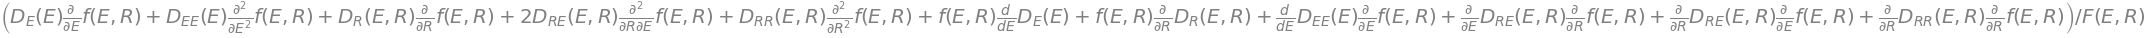

In [43]:
sol.simplify()

In [ ]:
        dE  = FiniteDifferenceUniformGrid(1, spatial_order, f, axis=0)
        dE2 = FiniteDifferenceUniformGrid(2, spatial_order, f, axis=0)
        dR  = FiniteDifferenceUniformGrid(1, spatial_order, f, axis=1)
        dR2 = FiniteDifferenceUniformGrid(2, spatial_order, f, axis=1)
        
        dER2.matrix = dE.matrix @ dR.matrix = dR.matrix @ dE.matrix
        
        D_EE, D_E, D_ER, D_RR, D_R = self._calc_coefficients()

        dE_D_EE = FiniteDifferenceUniformGrid(1, spatial_order, D_EE, axis=0).operate()
        dE_D_ER = FiniteDifferenceUniformGrid(1, spatial_order, D_ER, axis=0).operate()
        dE_D_E  = FiniteDifferenceUniformGrid(1, spatial_order, D_E, axis=0).operate()   
        dR_D_RR = FiniteDifferenceUniformGrid(1, spatial_order, D_RR, axis=1).operate()
        dR_D_ER = FiniteDifferenceUniformGrid(1, spatial_order, D_ER, axis=1).operate()
        dR_D_R  = FiniteDifferenceUniformGrid(1, spatial_order, D_R, axis=1).operate()
         
        fancy_F = np.sqrt(2)*(np.pi**3.)*(G*M)**(3.) (f.grids[0].values)**(-5./2.)
        
        D_E*dE + D_EE*dE2 + D_R*dR + D_RR*dR2 + f*dE_D_E + f*dR_D_R + dE*dE_D_EE + dR*dE_D_ER + dE*dR_D_ER + dR*dR_D_RR # + 2*D_ER*(second partial)

In [3]:
G = 6.674e-8 # gravitational constant, cgs
m = 2e33     # 1 solar mass in grams
M = 2e41     # 1e8 solar mass SMBH
N = 1e4      # number of stars in distribution

class FP_diffusion_2D:
    
    def __init__(self, X, dx2, dy2):
        
        self.X = X
        p = X.field_list[0]        
        self.domain = p.domain
        
        pt = Field(self.domain)
        
        LHS = pt - dx2 - dy2
        
        self.M = LHS.field_coeff(pt)
        self.L = LHS.field_coeff(p)
        
        #self.F_ops = [dx2+dy2]
               
class FP_drift_2D:
    
    def __init__(self, X, dx, dy):
        
        self.X = X
        p = X.field_list[0]        
        self.domain = p.domain

        pt = Field(self.domain)
        
        LHS = pt + dx + dy
        
        self.M = LHS.field_coeff(pt)
        self.L = LHS.field_coeff(p)
        
        #self.F_ops = []
        #self.F_ops = [-dx - dy]
    

    
class FokkerPlanck_SC:
    
    def __init__(self, X, rgrid, spatial_order=4):
      
        self.X = X
        self.r = rgrid
        f = self.X.field_list[0]
        
        self.domain = f.domain
        self.spatial_order = spatial_order

        
        # Returns field.Array instances: 
        self.dE  = FiniteDifferenceUniformGrid(1, spatial_order, f, axis=0)
        self.dE2 = FiniteDifferenceUniformGrid(2, spatial_order, f, axis=0)
        self.dR  = FiniteDifferenceUniformGrid(1, spatial_order, f, axis=1)
        self.dR2 = FiniteDifferenceUniformGrid(2, spatial_order, f, axis=1)
        
        f0 = 1
        
        convergence_order = 4
        self.BCs = [Left(0,convergence_order,f,f0,axis=0),Right(0,convergence_order,f,0,axis=0),
                   Left(0,convergence_order,f,0,axis=1),Right(0,convergence_order,f,0,axis=1)]
        
        
        self.ts = CrankNicolson(self,axis='full')
        
        self.t = 0.
        self.iter = 0
        
    def _potential(self,r):
        # For now, assumes SMBH potential
        return G*M/r
    
    def _dpotential_dr(self,r):
        # For now, assumes SMBH potential
        return -G*M/r/r


    def _calc_fbar(self):
        f = self.X.field_list[0]
        
        grid_E = f.domain.grids[0]
        grid_R = f.domain.grids[1]
        fbar_domain = field.Domain((grid_E, self.r))
        fbar = field.Field(fbar_domain)

        E_data = np.copy(grid_E.values)
        R_data = np.copy(grid_R.values)
        r_data = np.copy(self.r.values)


        # Construct an integrand that is a 3D grid in (E, r, R) space; trapz() will integrate out the R dimension. 
        r = r_data[None,:,None]
        E = E_data[:,None,None]

        Jc   = np.sqrt(self._dpotential_dr(r)*r**3.)
        Rmax = 2*r*(self._potential(r)-E)/Jc**2.

        # R varies from 0 to Rmax. Assume R grid starts at 0!
        R = R_data[None,None,:]
        integrand = (R<Rmax)*f.values[:,None,:]/(Rmax - R)**0.5

        # for output data
        np.copyto(fbar.data, (1./2./Rmax[:,:,0]**0.5)*trapz(integrand, R, axis=-1))

        return fbar

    def _calc_F012(self, fbar):
        Lambda = 0.4*N
        Gamma = 4*pi*G*G*m*m*np.log(Lambda) # Lambda ~ logarithmic cutoff factor, G ~ gravitational constant, m ~ mass of individual star

        grid_E = fbar.domain.grids[0]
        grid_r = fbar.domain.grids[1]    

        # Check to make sure arrays dont occupy same place in memory. the '[:]' part does this for us, I think?
        E_data = np.copy(grid_E.values)
        Eprime_Data = np.copy(E_data)
        r_data = np.copy(grid_r.values)
        pot = self._potential(r_data)[None,:,None]
        
        E  = E_data[:,None,None]
        Ep = Eprime_data[None,None,:]
        r  = r_data_data[None,:,None]

        ### F0
        F0_integrand = np.copy(fbar.data)*(Ep<E)
        F0 = 4*np.pi*Gamma*trapz(F0_integrand, Ep,axis=-1)

        ### F1
        F1_integrand = fbar.data * ((pot - Ep)/(pot - E))**(0.5)
        F1 = 4*np.pi*Gamma*trapz(F1_integrand, Ep,axis=-1)

        ### F2
        F2_integrand = fbar.data * ((pot - Ep)/(pot - E))**(1.5)
        F2 = 4*np.pi*Gamma*trapz(F2_integrand, Ep,axis=-1)    

        return F0, F1, F2

    def _calc_diffusion_coefficients(self, fbar, F0, F1, F2):
        f = self.X.field_list[0]
        grid_E = fbar.domain.grids[0]
        grid_R = f.domain.grids[1]
        grid_r = fbar.domain.grids[1]

        E = grid_E[:,None,None]
        R = grid_R[None,:,None]
        r = grid_r[None,None,:]

        # Need to calculate: vc, vt, vr, v, Jc, J
        Jc   = np.sqrt(-1*self._dpotential_dr(r)*r**3.) # angular momentum of circular orbit at given radius
        rc   = E/(2*G*M)                       # circular radius associated with E (E is the negative specific energy, i.e. is positive for all bound orbits)
        # R = J/Jc
        J    = R*Jc                  # angular momentum
        pot  = self._potential(r)    # potential energy (positive)
        v2   = 2*(pot - E)           # total velocity squared
        vr   = (v2 - J*J/r/r)**(0.5) # radial velocity
        vt   = (v2 - vr*vr)**(0.5)   # tangential velocity
        vc   = Jc*Jc/rc/rc           # tangential velocity associated with a circular orbit

        # calculate integrals

        ## Appendix C of Cohn 1979
        # D_EE  
        D_EE_integrand = (1./vr)*v2*(F0[:,None,:]+F2[:,None,:])
        D_EE           = 8*np.pi*np.pi/3*Jc*Jc * trapz(D_EE_integrand, r, axis = -1)

        # D_E
        D_E_integrand  = F1[:,None,:]/vr
        D_E            = -8.*np.pi*np.pi*Jc*Jc * trapz(D_E_integrand, r, axis = -1)

        # D_ER
        D_ER_integrand = (v2/vc/vc - 1)/vr * (F0[:,None,:]+F2[:,None,:])
        D_ER           = 16*np.pi*np.pi/3.*J*J * trapz(D_ER_integrand, r, axis = -1)

        # D_RR
        D_RR_integrand = (1./v2)*(2*r*r/v2 * ( vt*vt*(v2/vc/vc - 1)**2. + vr*vr)*F0[:,None,:] + 3*r*r*vr*vr/v2*F1[:,None,:] + r*r/v2*(2*vt*vt*(v2/vc/vc - 1)**2. - vr*vr)*F2[:,None,:])
        D_RR           = 16*np.pi*np.pi/3. * R * trapz(D_RR_integrand, r, axis = -1)

        # D_R
        D_R_integrand  = (1./vr)*(1. - vc*vc/v2)*F1[:,None,:]
        D_R            = -16*np.pi*np.pi*R*rc*rc * trapz(D_R_integrand, r, axis = -1)

        return D_EE, D_E, D_ER, D_RR, D_R
    
    def _calc_F(self, fbar):
        f = self.X.field_list[0]
        grid_E = fbar.domain.grids[0]
        grid_R = f.domain.grids[1]
        grid_r = fbar.domain.grids[1]

        E = grid_E[:,None,None]
        R = grid_R[None,:,None]
        r = grid_r[None,None,:]
        Jc   = np.sqrt(-1*self._dpotential_dr(r)*r**3.) # angular momentum of circular orbit at given radius
        rc   = E/(2*G*M)                       # circular radius associated with E (E is the negative specific energy, i.e. is positive for all bound orbits)
        # R = J/Jc
        J    = R*Jc                  # angular momentum
        pot  = self._potential(r)    # potential energy (positive)
        v2   = 2*(pot - E)           # total velocity squared
        vr   = (v2 - J*J/r/r)**(0.5) # radial velocity
        
        r_minus = (GM/E)*(1 - np.sqrt(1. - E*J*J/GM/GM))
        r_plus  = (GM/E)*(1 + np.sqrt(1. - E*J*J/GM/GM))

        bool1 = (r>r_minus)
        bool2 = (r<r_plus)
        vr    = np.sqrt(2*GM/r - 2*E - J*J/r/r)

        integrand = 1/vr * bool1 * bool2

        F = trapz(integrand,r,axis=-1)

        return F*Jc*Jc*4*np.pi*np.pi
        
    def _calc_coefficients(self):
        fbar     = self._calc_fbar()
        F0,F1,F2 = self._calc_F012(fbar)
        D_EE, D_E, D_ER, D_RR, D_R = self._calc_diffusion_coefficients(fbar,F0,F1,F2)        
        F = self._calc_F(fbar)
    
        domain = self.X.field_list[0].domain
        return field.Array(domain,D_EE), field.Array(domain,D_E), field.Array(domain,D_ER), field.Array(domain,D_RR), field.Array(domain,D_R), field.Array(domain,F)
    
    def _recalc_equation(self):
        D_EE, D_E, D_ER, D_RR, D_R, F = self._calc_coefficients()

        dE_D_EE = FiniteDifferenceUniformGrid(1, self.spatial_order, D_EE, axis=0).operate()
        dE_D_ER = FiniteDifferenceUniformGrid(1, self.spatial_order, D_ER, axis=0).operate()
        dE_D_E  = FiniteDifferenceUniformGrid(1, self.spatial_order, D_E, axis=0).operate()   
        dR_D_RR = FiniteDifferenceUniformGrid(1, self.spatial_order, D_RR, axis=1).operate()
        dR_D_ER = FiniteDifferenceUniformGrid(1, self.spatial_order, D_ER, axis=1).operate()
        dR_D_R  = FiniteDifferenceUniformGrid(1, self.spatial_order, D_R, axis=1).operate()
         
        f       = self.X.field_list[0]
        
        LHS = (-1/F)*(D_E*self.dE + D_EE*self.dE2 + D_R*self.dR + D_RR*self.dR2 + f*dE_D_E + f*dR_D_R + dE*dE_D_EE + dR*dE_D_ER + dE*dR_D_ER + dR*dR_D_RR) # + 2*D_ER*(second partial)         
        
            
        # update this: 
        ft = Field(self.domain)
        
        
        
        M = LHS.field_coeff(ft)
        M = M.tocsr()
        M[:1,:] = self.BCs[0].field_coeff(ft)
        M[-1:,:] = self.BCs[1].field_coeff(ft)
        M[:,:1] = self.BCs[2].field_coeff(ft)
        M[:,-1:] = self.BCs[3].field_coeff(ft)
        M.eliminate_zeros()
        self.M = M
    
        L = LHS.field_coeff(f)
        L = L.tocsr()
        L[:1,:] = self.BCs[0].field_coeff(f)
        L[-1:,:] = self.BCs[1].field_coeff(f)
        L[:,:1] = self.BCs[2].field_coeff(f)
        L[:,-1:] = self.BCs[3].field_coeff(f)
        L.eliminate_zeros()
        self.L = L
        
        
    def step(self, dt):

        self._recalc_equation()
        self.ts.step(dt)
        self.t += dt
        self.iter += 1

### $f(E,R) = e^{aE+bR}$
### $\frac{\partial^2 f}{dEdR} = abe^{aE+bR}$

In [103]:
N = 100
spatial_order = 4

a = 3.2
b = 4.9

grid_E = field.UniformPeriodicGrid(N // 2,2*np.pi)
grid_R = field.UniformPeriodicGrid(N,2*np.pi)
domain = field.Domain((grid_E, grid_R))
f = field.Field(domain)

f.data = np.exp(a*grid_E.values[:,None]+b*grid_R.values[None,:])
solution = a*b*np.exp(a*grid_E.values[:,None]+b*grid_R.values[None,:])


if 0:
    dE  = FiniteDifferenceUniformGrid(1, spatial_order, f, axis=0).operate()
    dER = FiniteDifferenceUniformGrid(1, spatial_order, dE, axis=1).operate()

if 1:
    dE  = FiniteDifferenceUniformGrid(1, spatial_order, f, axis=0)
    dR  = FiniteDifferenceUniformGrid(1, spatial_order, f, axis=1)
    dER  = field.LinearOperator(f)
    
    print(dE.matrix.shape, dR.matrix.shape)
    
    dE = shape[50, 50]
    
    for every u_{E=i,R} apply 
    a_0 u_{E=0,R}, ... a_N u_{E_N, R}
    
    
    
    
    print(type(dE.matrix))
    
    #dER._full_matrix = sparse.bmat([])

    
    dER._full_matrix.shape = (50*100,50*100)
    
    print(dE.operate().data.shape)
    print(dR.matrix.shape)
    dER = dR.matrix @ dE.operate().data# @ dR#.axis = 'full'

    #dER.matrix = dE.matrix @ dR.matrix
    print(type(dER))
    dER.evaluate()
if 0:
    dE  = FiniteDifferenceUniformGrid(1, spatial_order, f, axis=0)
    dR  = FiniteDifferenceUniformGrid(1, spatial_order, f, axis=1)
    
    dE_field = field.Field(domain)
    dE_field.data  = apply_matrix(dE.matrix, f.multi_data(), 0)
    dER_field = field.Field(domain)
    dER_field.data = apply_matrix(dR.matrix, dE_field.multi_data(), 1)
if 0:
    dE  = FiniteDifferenceUniformGrid(1, spatial_order, f, axis=0)
    dR  = FiniteDifferenceUniformGrid(1, spatial_order, f, axis=1)

    dER = dE*dR
    x = dER.field_coeff(f)
    
    print(type(x))
    
    
    print(type(dER), type(f))

R_ind = N//2

plt.plot(grid_E.values, dER_field.data[:,R_ind],label='appx')
plt.plot(grid_E.values, solution[:,R_ind],label='sol')
plt.legend(loc='upper left', frameon=False)

plt.ylim(0,5e16)

(50, 50) (100, 100)
<class 'scipy.sparse.csr.csr_matrix'>


AttributeError: 'LinearOperator' object has no attribute 'axis'

In [104]:


I = sparse.diags([1], 0, shape=(10,10))
I_tiled = sparse.diags([])
I --> (100, 100)

F =
print(I)

  (0, 0)	1.0
  (1, 1)	1.0
  (2, 2)	1.0
  (3, 3)	1.0
  (4, 4)	1.0
  (5, 5)	1.0
  (6, 6)	1.0
  (7, 7)	1.0
  (8, 8)	1.0
  (9, 9)	1.0
